In [1]:
# Imports
!pip install cpmpy --quiet
!pip install --upgrade cpmpy --quiet
! pip install matplotlib --quiet
import cpmpy as cp
import time
import numpy as np
import math
import matplotlib.pyplot as plt

(You can ignore google* and tensor* dependency errors on Google Colab.)


## **Session 3: Global Constraints**

In this session we will get more familiar with global constraints, and how to use them to model combinatorial problems.
Global constraints seen in the lecture:
* AllDifferent
* AllDifferentExcept0
* GlobalCardinalityCount
* Cumulative
* NoOverlap
* Circuit
* Table
* Count
* NValues
* Element

In CPMpy Count, Nvalues and Element are global functions, Count(arr,elem) == n, is equivalent with the global constraint CountEq(arr,elem,n)

Global constraints simplify modeling and can improve solving efficiency.  
To demonstrate this, and show how to use the decompose method, we'll solve the pigeonhole problem using global constraints and their decomposition.
CPMpy provides decompositions for all global constraints, used when not natively supported.
A global constraint's decomposition is accessed using the `.decompose()` method.

Read the following models of the pigeonhole problem, and see if you understand the use of global constraints and their decompositions.
Execute both models to see the difference in runtime.

**Useful Resources:**
* CPMpy summary sheet: https://cpmpy.readthedocs.io/en/latest/summary.html
* CPMpy modeling documentation: https://cpmpy.readthedocs.io/en/latest/modeling.html

In [2]:
# example of modelling the pigeonhole problem with global constraints or with its decomposition

n = 400 # number of pigeons
m = 92 # number of holes

pigeon = cp.intvar(1,m, shape=n) # which hole is each pigeon in

model = cp.Model()

# global constraint
model.add(cp.AllDifferent(pigeon)) # each pigeon in a different hole

start_time = time.time()
result = model.solve()
end_time = time.time()

print(f"Solving time: {end_time - start_time:.4f} seconds")
print(f"Solution: {result}")

Solving time: 0.2935 seconds
Solution: False


In [3]:
# Decomposed constraints
model_decomposed = cp.Model()

# Decompose AllDifferent constraint for pigeons
model_decomposed += cp.AllDifferent(pigeon).decompose()

start_time_decomposed = time.time()
result_decomposed = model_decomposed.solve()
end_time_decomposed = time.time()

print("\nDecomposed version:")
print(f"Solving time: {end_time_decomposed - start_time_decomposed:.4f} seconds")
print(f"Solution: {result_decomposed}")

# Compare the two approaches
print("\nComparison:")
print(f"Global constraints time: {end_time - start_time:.4f} seconds")
print(f"Decomposed constraints time: {end_time_decomposed - start_time_decomposed:.4f} seconds")


Decomposed version:
Solving time: 4.0732 seconds
Solution: False

Comparison:
Global constraints time: 0.2935 seconds
Decomposed constraints time: 4.0732 seconds


As you can see the solver has better propagation with the native global constraints, than with its decomposition. This makes it faster in proving the unsatisfiability of this specific instance of the pigeonhole problem.
Make sure you understand the way we modelled the pigeonhole problem, and the use of AllDifferent.

## **Exercise 1: Sudoku variant**

In the following sudoku variant you have to fill in the numbers from 1 to 5 once each in every row, column and block.
However, the grid can be bigger than 5x5, and it is allowed to have any number of 0's in the final solution.


In [4]:
# Here's our puzzle (-1 represents empty cells):
puzzle = cp.cpm_array([
    [-1,3,-1, -1,5,-1, -1,-1,-1],
    [-1,-1,-1, 1,-1,-1, -1,-1,-1],
    [-1,-1,-1, -1,-1,-1, -1,5,-1],

    [5,-1,-1, 0,0,-1, -1,-1,3],
    [4,-1,-1, 5,-1,3, -1,-1,1],
    [-1,-1,-1, -1,2,-1, -1,-1,-1],

    [-1,5,-1, -1,-1,-1, 2,-1,0],
    [-1,-1,-1, 4,1,0, -1,-1,-1],
    [0,0,0, -1,-1,-1, -1,-1,-1]
])

# Create variables for the grid
grid = cp.intvar(0, 5, shape=(9, 9))

# Create the model
model = cp.Model()

# Fix the known values
model.add([grid[i,j] == puzzle[i,j] for i in range(9) for j in range(9) if puzzle[i,j] != -1])

# Each row must have different non-zero values
model.add([cp.AllDifferentExcept0(grid[i,:]) for i in range(9)])

# Each column must have different non-zero values
model.add([cp.AllDifferentExcept0(grid[:,j]) for j in range(9)])

# Each 3x3 block must have different non-zero values
model.add([cp.AllDifferentExcept0(grid[i:i+3, j:j+3])
          for i in range(0,9,3) for j in range(0,9,3)])

# Each number needs to appear 9 times in the correct puzzle
model.add([cp.Count(grid, i) == 9 for i in range(1,6)])
# equivalent counting constraint with gcc
model.add(cp.GlobalCardinalityCount(grid,[1,2,3,4,5],[9,9,9,9,9]))

# Solve the model
if model.solve():
    print("Solution found:")
    for row in grid.value():
        print(row)
else:
    print("No solution found.")

Solution found:
[0 3 2 0 5 0 4 1 0]
[0 4 5 1 0 0 3 0 2]
[0 1 0 3 4 2 0 5 0]
[5 2 1 0 0 4 0 0 3]
[4 0 0 5 0 3 0 2 1]
[3 0 0 0 2 1 5 4 0]
[1 5 4 0 3 0 2 0 0]
[2 0 3 4 1 0 0 0 5]
[0 0 0 2 0 5 1 3 4]


Alternative solution using GCC instead of AllDifferentExcept0

In [5]:
# Here's our puzzle (-1 represents empty cells):
puzzle = cp.cpm_array([
    [-1,3,-1, -1,5,-1, -1,-1,-1],
    [-1,-1,-1, 1,-1,-1, -1,-1,-1],
    [-1,-1,-1, -1,-1,-1, -1,5,-1],

    [5,-1,-1, 0,0,-1, -1,-1,3],
    [4,-1,-1, 5,-1,3, -1,-1,1],
    [-1,-1,-1, -1,2,-1, -1,-1,-1],

    [-1,5,-1, -1,-1,-1, 2,-1,0],
    [-1,-1,-1, 4,1,0, -1,-1,-1],
    [0,0,0, -1,-1,-1, -1,-1,-1]
])

# Create variables for the grid
grid = cp.intvar(0, 5, shape=(9, 9))

# Create the model
model = cp.Model()

# Fix the known values
model.add([grid[i,j] == puzzle[i,j] for i in range(9) for j in range(9) if puzzle[i,j] != -1])


# count the numbers in each row column and block.
# counting the 0's is optional since this is the only available option other that 1-5. If our grid variable allowed other values this would not be the case.
for i in range(0,9):
    model.add(cp.GlobalCardinalityCount(grid[i,:],[1,2,3,4,5], [1,1,1,1,1]))
    model.add(cp.GlobalCardinalityCount(grid[:,i],[0,1,2,3,4,5], [4,1,1,1,1,1]))

model.add([cp.GlobalCardinalityCount(grid[i:i+3, j:j+3], [0,1,2,3,4,5], [4,1,1,1,1,1])
          for i in range(0,9,3) for j in range(0,9,3)])


# Solve the model
if model.solve():
    print("Solution found:")
    for row in grid.value():
        print(row)
else:
    print("No solution found.")

Solution found:
[0 3 0 0 5 0 4 1 2]
[2 0 5 1 4 0 3 0 0]
[0 4 1 3 0 2 0 5 0]
[5 0 2 0 0 1 0 4 3]
[4 0 0 5 0 3 0 2 1]
[3 1 0 0 2 4 0 0 5]
[1 5 4 0 3 0 2 0 0]
[0 2 3 4 1 0 5 0 0]
[0 0 0 2 0 5 1 3 4]


## **Exercise 2: Traveling Salesman Problem**

Complete the following optimization problem to find the shortest route that visits all cities exactly once.  
We have already defined a function that generates the distance matrix from a list of coordinates.


In [6]:
def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    n_city = len(locations)
    distances = np.zeros((n_city,n_city))
    for from_counter, from_node in enumerate(locations):
        for to_counter, to_node in enumerate(locations):
            if from_counter != to_counter:
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances.astype(int)
locations= [
        (288, 149), (288, 129), (270, 133), (256, 141), (256, 163), (246, 157),
        (236, 169), (228, 169), (228, 148), (220, 164), (212, 172), (204, 159)
]

distance_matrix = compute_euclidean_distance_matrix(locations)
distance_matrix = cp.cpm_array(distance_matrix) # this allows us to index the distance matrix with a cpmpy expression
print(distance_matrix)


[[ 0 20 24 32 34 42 55 63 60 69 79 84]
 [20  0 18 34 46 50 65 72 62 76 87 89]
 [24 18  0 16 33 33 49 55 44 58 69 70]
 [32 34 16  0 22 18 34 39 28 42 53 55]
 [34 46 33 22  0 11 20 28 31 36 44 52]
 [42 50 33 18 11  0 15 21 20 26 37 42]
 [55 65 49 34 20 15  0  8 22 16 24 33]
 [63 72 55 39 28 21  8  0 21  9 16 26]
 [60 62 44 28 31 20 22 21  0 17 28 26]
 [69 76 58 42 36 26 16  9 17  0 11 16]
 [79 87 69 53 44 37 24 16 28 11  0 15]
 [84 89 70 55 52 42 33 26 26 16 15  0]]


### Decision Variables

Define the decision variables as integers in an array <code>x</code>, where <code>x[i]=j</code> means that city <code>j</code> is visited immediately after <code>i</code>.  
Hence each <code>x[i]</code> will take a value of at least 0 and at most <code>n_city-1</code>, with <code>x</code> of length <code>n_city</code>.

In [7]:
n_city = len(locations)
model = cp.Model()
# Define decision variables
x = cp.intvar(0,n_city-1, shape=n_city)
# Define the objective, total travel distance should be minimized
model.minimize(sum([distance_matrix[i,x[i]] for i in range(n_city)]))
# Add constraints (find the appropriate global constraints to use)
model.add(cp.Circuit(x))


# solving:
model.solve()
val = model.objective_value() # the resulting objective value.
print("Dist:",val,"; solution:",x.value())

Dist: 211 ; solution: [ 1  2  3  8  0  4  5  6 11  7  9 10]


Running the next cell will visualize the solution. The correct solution has a distance of 211.


0 --> 1 --> 2 --> 3 --> 8 --> 11 --> 10 --> 9 --> 7 --> 6 --> 5 --> 4 --> 0


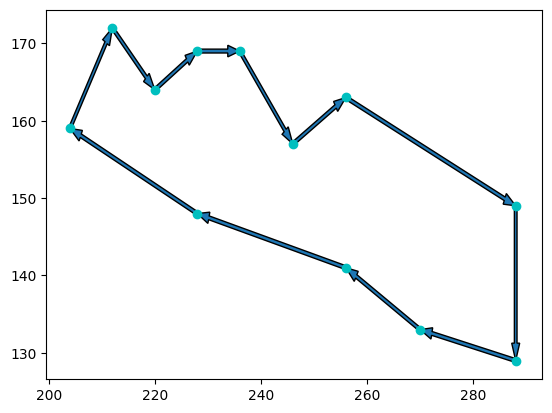

In [8]:
def display(sol):
    x = 0
    msg = "0"
    while sol[x] != 0:
        x = sol[x]
        msg += f" --> {x}"
    print(msg + " --> 0")

display(x.value())

def plot_tsp(coords, sol):
    coords = np.array(coords)
    plt.plot(coords[:,0], coords[:,1], 'co')
    
    for source,dest in enumerate(sol):
        x,y = coords[source]
        dx,dy = coords[dest] - coords[source]
        plt.arrow(x,y,dx,dy, width=0.5, length_includes_head = True)
    
    return plt.show()
    

plot_tsp(locations, x.value())

## Exercise 3:
You have to assign 3 different students to a timeslot with their professor, the available slots are numbered from 0 to 9.
For some reason the professor let's you know that the only acceptable ways to assign the students are the following: (0,1,2), (2,5,8), (0,6,4), (1,3,7), (3,4,9), (5,6,7), (1,8,9), (0,3,9), (2,4,6), (1,5,8), (3,6,7), (0,4,8), (2,3,9), (1,6,7), (4,5,6).
Each student also needs to be accompanied by a supervisor, you need to assign one supervisor to each student, and the supervisors can only have one student each.
In addition, the first supervisor is only available on slots 2-9, the second supervisor on slots 4 and 5, and the third wants to be directly after the first, so they can take the same train.

Model these constraints using the appropriate Globals.


In [9]:

allowed_slots =[(0,1,2), (2,5,8), (0,6,4), (1,3,7), (3,4,9), (5,6,7), (1,8,9), (0,3,9), (2,4,6), (1,5,8), (3,6,7), (0,4,8), (2,3,9), (1,6,7), (4,5,6)]

model = cp.Model()
# Define decision variables
timeslots = cp.intvar(0,9,shape=3)
supervisor = cp.intvar(0,2,shape=3) #supervisor[i] = s means that student s is being supervised by supervisor i.
# Add constraints (find the appropriate global constraints to use)
model.add(cp.Table(timeslots, allowed_slots))
model.add(timeslots[supervisor[0]] >= 2)
#model += cp.Element(timeslots,supervisor[0]) >= 2  # this is another way to write the same constraint
model.add((timeslots[supervisor[1]] == 4) | (timeslots[supervisor[1]] == 5))
model.add(timeslots[supervisor[2]] == timeslots[supervisor[0]] + 1)

model.add(cp.AllDifferent(supervisor))
print(model)

if model.solve():
    print("Solution exists:", timeslots.value(), supervisor.value())
else:
    print("No solution found.")

Constraints:
    table([IV586, IV587, IV588],[(0, 1, 2), (2, 5, 8), (0, 6, 4), (1, 3, 7), (3, 4, 9), (5, 6, 7), (1, 8, 9), (0, 3, 9), (2, 4, 6), (1, 5, 8), (3, 6, 7), (0, 4, 8), (2, 3, 9), (1, 6, 7), (4, 5, 6)])
    [IV586 IV587 IV588][IV589] >= 2
    ([IV586 IV587 IV588][IV590] == 4) or ([IV586 IV587 IV588][IV590] == 5)
    ([IV586 IV587 IV588][IV591]) == (([IV586 IV587 IV588][IV589]) + 1)
    alldifferent(IV589,IV590,IV591)
Objective: None
Solution exists: [5 6 7] [1 0 2]


## Exercise 4: Labeled Dice
You want to put letters on 4 6-sided dice in such a way that you can arrange the dice to spell out any of the following words: buoy, cave, celt, flub, fork, hemp, judy, junk, limn, quip, swag, visa, wish.
There are 24 letters appearing in these words.

Write a model to solve this puzzle.
Hint: you can get the index of a letter x by using letters.index(x)


In [10]:
# Define the letters and words
letters = "abcdefghijklmnopqrstuvwy"
words = ["buoy", "cave", "celt", "flub", "fork", "hemp", "judy", "junk", "limn", "quip", "swag", "visa", "wish"]

# Define the number of dice and sides
nDice = 4
nSides = 6

# Define the variables
# l[i] = x means that the letter letters[i] is on cube x
l = cp.intvar(0,3 , shape=24)  # represents which dice each letter is on

# Define the model
dice_model = cp.Model()

# Add constraints to ensure each word can be spelled with the 4 dice.
for word in words:
    dice_model.add([cp.AllDifferent([l[letters.index(w)] for w in word])])


# each cube can only have 6 letters on it
dice_model.add(cp.GlobalCardinalityCount(l,[0,1,2,3], [6,6,6,6]))




Constraints:
    alldifferent(IV597,IV616,IV610,IV619)
    alldifferent(IV598,IV596,IV617,IV600)
    alldifferent(IV598,IV600,IV607,IV615)
    alldifferent(IV601,IV607,IV616,IV597)
    alldifferent(IV601,IV610,IV613,IV606)
    alldifferent(IV603,IV600,IV608,IV611)
    alldifferent(IV605,IV616,IV599,IV619)
    alldifferent(IV605,IV616,IV609,IV606)
    alldifferent(IV607,IV604,IV608,IV609)
    alldifferent(IV612,IV616,IV604,IV611)
    alldifferent(IV614,IV618,IV596,IV602)
    alldifferent(IV617,IV604,IV614,IV596)
    alldifferent(IV618,IV604,IV614,IV603)
    gcc([IV596,IV597,IV598,IV599,IV600,IV601,IV602,IV603,IV604,IV605,IV606,IV607,IV608,IV609,IV610,IV611,IV612,IV613,IV614,IV615,IV616,IV617,IV618,IV619],[0, 1, 2, 3],[6, 6, 6, 6])
Objective: None

In [11]:
# Solve the model
if dice_model.solve():
    # Visualize the solution
    print("Solution found!")
    print("\nDice configuration:")
    for i in range(nDice):
        print(f"Die {i+1}: ", end="")
        for letter_index in range(24):
            if l[letter_index].value() == i:
                print(letters[letter_index], end=" ")
        print()
    
    print("\nWords formation:")
    for word in words:
        print(f"{word}: ", end="")
        for letter in word:
            letter_index = letters.index(letter)
            die_number = l[letter_index].value() + 1
            print(f"{die_number}", end=" ")
        print()
else:
    print("No solution found.")

Solution found!

Dice configuration:
Die 1: a h j l o q 
Die 2: c f n p s y 
Die 3: m r t u v w 
Die 4: b d e g i k 

Words formation:
buoy: 4 3 1 2 
cave: 2 1 3 4 
celt: 2 4 1 3 
flub: 2 1 3 4 
fork: 2 1 3 4 
hemp: 1 4 3 2 
judy: 1 3 4 2 
junk: 1 3 2 4 
limn: 1 4 3 2 
quip: 1 3 4 2 
swag: 2 3 1 4 
visa: 3 4 2 1 
wish: 3 4 2 1 


## Exercise 5: RCPSP
The Resource-Constrained Project Scheduling Problem is a classical problem in operations research. A number of activities are to be scheduled. Each activity has a duration and cannot be interrupted. There are a set of precedence relations between pairs of activities which state that the second activity must start after the first has finished. There are a set of renewable resources. Each resource has a maximum capacity and at any given time slot no more than this amount can be in use. Each activity has a demand (possibly zero) on each resource. Minimize the completion time of the last activity

In [12]:
# Data, there are 12 tasks to be scheduled, with 2 resources that can be used.
# Task durations
durations = cp.cpm_array([1, 3, 2, 5, 4, 2, 3, 4, 2, 4, 6, 1])
# resources needed by the tasks
resource_needs = cp.cpm_array([[0, 0], [5, 1], [0, 4], [1, 4], [1, 3], [3, 2], [3, 1], [2, 4], [4, 0], [5, 2], [2, 5], [0, 0]])
# Total resource capacity
resource_capacities = cp.cpm_array([6, 8])
# precedence relations, successors_link(x,y) means that y can only start after x has finished
successors_link = cp.cpm_array([[0, 1], [0, 2], [0, 3], [1, 4], [1, 5], [2, 9], [2, 11], [3, 8], [4, 6], [4, 7], [5, 9], [5, 11], [6, 8], [6, 9], [7, 8], [8, 10], [9, 10], [11, 10]])

nb_resource = len(resource_capacities)
nb_jobs = len(durations)
max_duration = sum(durations)  # dummy upper bound, can be improved of course

# Variables, we need to find a list of starting times that satisfies all the constraints.
start_time = cp.intvar(0, max_duration, shape=nb_jobs)

rcpsp_model = cp.Model()

# Add precedence constraints
rcpsp_model.add([start_time[j] >= start_time[i] + durations[i] for i,j in successors_link])
# Add resource usage constraints
# cumulative constraint for each resource.
rcpsp_model.add(cp.Cumulative(start_time,durations, end=start_time+durations, demand=resource_needs[:,0], capacity=resource_capacities[0]))
rcpsp_model.add(cp.Cumulative(start_time,durations, end=start_time+durations, demand=resource_needs[:,1], capacity=resource_capacities[1]))
# minimize total execution time
rcpsp_model.minimize(cp.Maximum(start_time + durations))


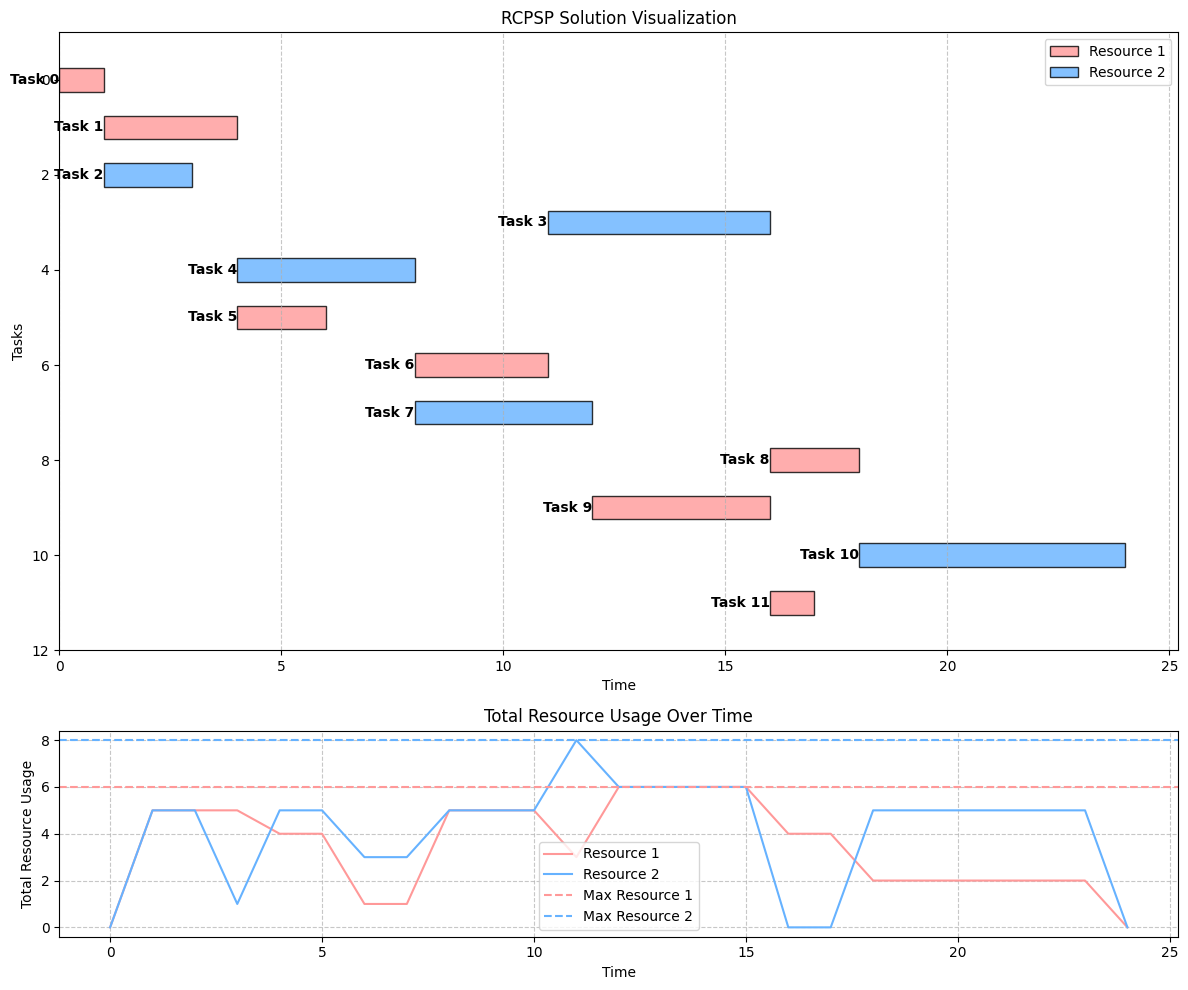

Makespan: 24


In [13]:
# Visualize the RCPSP solution
rcpsp_model.solve()

# Get the solution values
start_times = start_time.value()
end_times = start_times + np.array(durations)

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# Define colors for each resource
colors = ['#FF9999', '#66B2FF']

# Plot each task as a horizontal bar
for i in range(nb_jobs):
    if durations[i] > 0:  # Skip tasks with zero duration
        ax1.barh(i, durations[i], left=start_times[i], height=0.5,
                 color=colors[np.argmax(resource_needs[i])],
                 alpha=0.8, edgecolor='black')

        # Add task labels
        ax1.text(start_times[i], i, f'Task {i}', va='center', ha='right', fontweight='bold')

# Customize the task plot
ax1.set_xlabel('Time')
ax1.set_ylabel('Tasks')
ax1.set_title('RCPSP Solution Visualization')
ax1.set_ylim(-1, nb_jobs)
ax1.invert_yaxis()  # Invert y-axis to have task 0 at the top

# Add a legend for tasks
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='black', alpha=0.8, label=f'Resource {i+1}') for i in range(nb_resource)]
ax1.legend(handles=legend_elements, loc='upper right')

# Show the grid for tasks
ax1.grid(True, axis='x', linestyle='--', alpha=0.7)

# Calculate total resource usage over time
max_time = max(end_times)
resource_usage = np.zeros((nb_resource, max_time + 1))
for i in range(nb_jobs):
    for t in range(start_times[i], end_times[i]):
        for r in range(nb_resource):
            resource_usage[r, t] += resource_needs[i, r]

# Plot total resource usage
for r in range(nb_resource):
    ax2.plot(range(max_time + 1), resource_usage[r], label=f'Resource {r+1}', color=colors[r])

# Plot maximal allowed usage
for r in range(nb_resource):
    ax2.axhline(y=resource_capacities[r], color=colors[r], linestyle='--',
                label=f'Max Resource {r+1}')

ax2.set_xlabel('Time')
ax2.set_ylabel('Total Resource Usage')
ax2.set_title('Total Resource Usage Over Time')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the makespan (total project duration)
print(f"Makespan: {max(end_times)}")


The next cell will check if your solution is valid. The optimal makespan should be 24.

In [14]:
def check_solution(start_time_values):
    for j in range(successors_link.shape[0]):
        assert start_time_values[successors_link[j, 1]] >= start_time_values[successors_link[j, 0]]+\
               durations[successors_link[j, 0]]
    for t in range(max(start_time_values)+1):
        active_index = [i for i in range(nb_jobs) if durations[i] > 0 and
                        start_time_values[i] <= t < start_time_values[i]+durations[i]]
        for r in range(nb_resource):
            consumption = sum([resource_needs[i, r] for i in active_index])
            if consumption>resource_capacities[r]:
                print(t, r, consumption, resource_capacities[r])
            assert consumption <= resource_capacities[r]



check_solution(start_time.value())
print("Solution passed all checks.")

Solution passed all checks.


## Exercise 6: Board coloring
A chess board of dimensions n by m has to be colored in such way that no 2x2 square is completely of one colour. Minimise the amount of colours used.
Extra: Try adding extra constraints to get more interesting solutions:
- have a color that is used twice as much as another color
- adjust your model such that each 2x2 square needs to have at least 3 different colours, what about 4 different colours?

In [15]:

n, m = 6,7

# x[i][j] is the color at row i and column j
x = cp.intvar(0, n*m, shape=(n,m))

board_model = cp.Model()

# at least 2 corners of different colors for any rectangle inside the board
board_model.add([cp.NValue([x[i1][j1], x[i1][j2], x[i2][j1], x[i2][j2]]) > 1  #2 if at least 3 different colours
      for i1 in range(n-1)
      for j1 in range(m-1)
      for i2 in [i1+1]
      for j2 in [j1+1]])

'''# if you want all 4 colours to be different you could use AllDifferent instead of NValue
board_model.add([cp.AllDifferent([x[i1][j1], x[i1][j2], x[i2][j1], x[i2][j2]]) > 1  #2 if at least 3 different colours
      for i1 in range(n-1)
      for j1 in range(m-1)
      for i2 in [i1+1]
      for j2 in [j1+1]])
'''

# have a colour be twice as present as another
board_model.add(cp.Count(x, 0) == 2*cp.Count(x,1))
board_model.add(cp.Count(x,0) > 0)

board_model.minimize(
   # minimizing the greatest used color index (and so, the number of colors)
   cp.NValue(x)
)

Solution found!
[[1 1 1 0 1 1 0]
 [1 0 1 1 0 0 0]
 [0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0]]


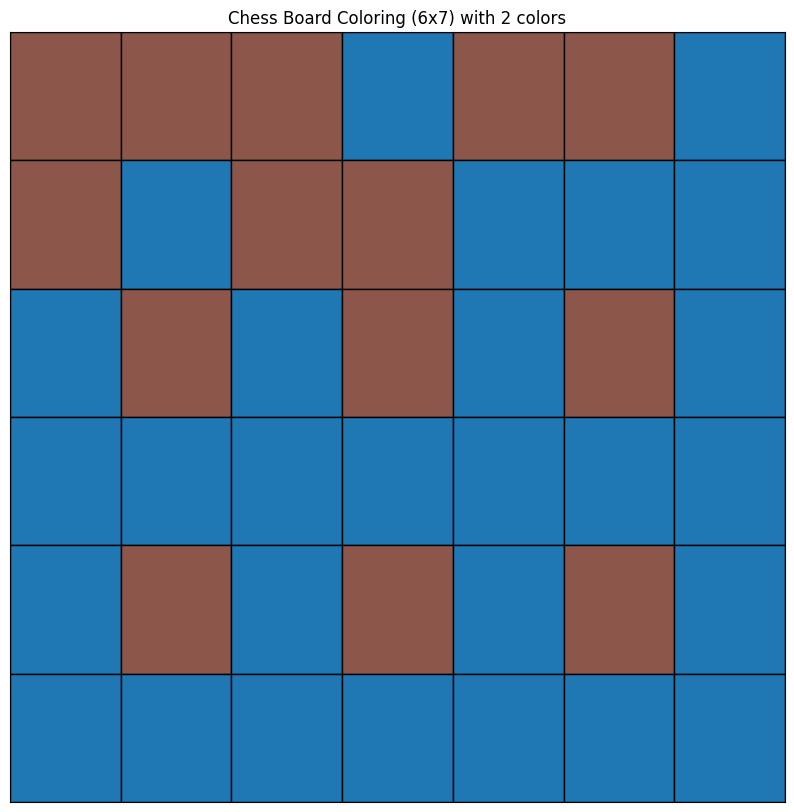

In [16]:
# Solve the model
if board_model.solve():
    print("Solution found!")
    solution = x.value()
    print(solution)
    # Import necessary libraries for visualization
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a colormap
    num_colors = len(np.unique(solution))
    cmap = plt.get_cmap('tab20')  # You can change this to other colormaps like 'Set3', 'Paired', etc.
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot each cell with its color
    for i in range(n):
        for j in range(m):
            color = cmap(solution[i, j] / num_colors)
            ax.add_patch(plt.Rectangle((j, n-1-i), 1, 1, facecolor=color, edgecolor='black'))
    
    # Set the limits and remove axis ticks
    ax.set_xlim(0, m)
    ax.set_ylim(0, n)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a title
    plt.title(f"Chess Board Coloring ({n}x{m}) with {num_colors} colors")
    
    # Show the plot
    plt.show()
else:
    print("No solution found.")


# Extra's
## Exercise : Pizza Voucher Problem

There is a large order of pizzas for a party, and many of the students have vouchers for acquiring discounts in purchasing pizzas. A voucher is a pair of numbers e.g. (2,4), which means if you pay for 2 pizzas then you can obtain for free up to 4 pizzas as long as they each cost no more than the cheapest of the
pizzas you paid for. Similarly a voucher (3,2) means that if you pay for 3 pizzas you can get up to 2 pizzas for free as long as they each cost no more than the cheapest of the 3 pizzas you paid for. The aim is to obtain all the ordered pizzas for the least possible cost. Note that not all vouchers need to be used.
Hint: start by defining the objective, and run the model after each constraint you add. Is the result what you expected?


In [17]:
prices = [50, 60, 90, 70, 80, 100, 20, 30, 40, 10]  # prices of pizzas
vouchers = [
    (1, 2), (2, 3), (1, 1), (0, 1), (2, 1),
    (2, 2), (3, 3), (1, 0), (3, 2)]  # available vouchers

nPizzas = len(prices)
nVouchers = len(vouchers)

# Decision variables:

# what voucher is used for each pizza, negative means the pizza has to be paid,
# positive means it is free. 0 means no voucher is used
# take care, this means we are using 'prices' and 'vouchers' with indexes starting from 1, and not 0.
v = cp.intvar(-nVouchers, nVouchers, shape=nPizzas)

# define variables that keep track of how many free and paid pizza's each voucher has.
p = cp.intvar(0, nPizzas, shape=nVouchers)
f = cp.intvar(0, nPizzas, shape=nVouchers)

# model the constraints:
pizza_model = cp.Model()

# number of paid and free pizza's in f and p must correspond to the voucher data in v.
pizza_model.add([p[i] == cp.Count(v, -(i + 1)) for i in range(nVouchers)])
pizza_model.add([f[i] == cp.Count(v, i + 1) for i in range(nVouchers)])
# voucher can only have free pizza's on it if it has enough paid pizza's
pizza_model.add([(f[i] > 0).implies(p[i] == vouchers[i][0]) for i in range(nVouchers)])
# a voucher can not have too many free pizza's on it
pizza_model.add([f[i] <= vouchers[i][1] for i in range(nVouchers)])
# free pizza's must be cheaper than paid pizza's
pizza_model.add([(v[i] > 0).implies(v[i] != -v[j]) for i in range(nPizzas) for j in range(nPizzas) if
                prices[j] < prices[i]])

#minimize the total price
pizza_model.minimize(sum([(v[i] <= 0) * prices[i] for i in range(nPizzas)]))


In [18]:

# Solve the model
if pizza_model.solve():
    print("Optimal solution found!")
    print('vouchers used: ', v.value())
    print('paid: ', p.value())
    print('free: ', f.value())

    # Calculate total cost
    total_cost = pizza_model.objective_value()
    print(f"Total cost: {total_cost}")

    # Visualize the solution
    print("\nPizza allocation:")
    for i in range(1, nPizzas + 1):
        pizza_status = v[i - 1].value()
        if pizza_status == 0:
            print(f"Pizza {i} (${prices[i - 1]}): Paid (no voucher)")
        elif pizza_status < 0:
            print(f"Pizza {i} (${prices[i - 1]}): Paid (part of voucher {abs(pizza_status)})")
        else:
            print(f"Pizza {i} (${prices[i - 1]}): Free (using voucher {pizza_status})")

    print("\nVoucher usage:")
    for i in range(1, nVouchers + 1):
        if p[i - 1].value() > 0 or f[i - 1].value() > 0:
            print(f"Voucher {i} ({vouchers[i - 1]}): {p[i - 1].value()} paid, {f[i - 1].value()} free")
else:
    print("No solution found.")

Optimal solution found!
vouchers used:  [-2 -2 -1  1  1  4  2  2  2 -9]
paid:  [1 2 0 0 0 0 0 0 1]
free:  [2 3 0 1 0 0 0 0 0]
Total cost: 210

Pizza allocation:
Pizza 1 ($50): Paid (part of voucher 2)
Pizza 2 ($60): Paid (part of voucher 2)
Pizza 3 ($90): Paid (part of voucher 1)
Pizza 4 ($70): Free (using voucher 1)
Pizza 5 ($80): Free (using voucher 1)
Pizza 6 ($100): Free (using voucher 4)
Pizza 7 ($20): Free (using voucher 2)
Pizza 8 ($30): Free (using voucher 2)
Pizza 9 ($40): Free (using voucher 2)
Pizza 10 ($10): Paid (part of voucher 9)

Voucher usage:
Voucher 1 ((1, 2)): 1 paid, 2 free
Voucher 2 ((2, 3)): 2 paid, 3 free
Voucher 4 ((0, 1)): 0 paid, 1 free
Voucher 9 ((3, 2)): 1 paid, 0 free
